In [1]:
import numpy as np
from scipy.linalg import expm
import random

class move_gym():
    def __init__(self):
        self.scope = 2.0
        self.states = 6
        self.actions = 4
    def reset(self):

        self.obstacle_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.obstacle_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1

        self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1  
        while ( abs(self.obstacle_x-self.move_x) < 1.0 ) & ( abs(self.obstacle_y-self.move_y) < 1.0 ):
            self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1      

        self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
        while (  ( abs(self.obstacle_x-self.target_x) < 1.0 ) & ( abs(self.obstacle_y-self.target_y) < 1.0 )  ) |\
         (  ( abs(self.move_x-self.target_x) < 1.0 ) & ( abs(self.move_y-self.target_y) < 1.0 )  ):
            self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1        


        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])
        return state #, self.state2img(state)
    def step(self, action):
        velocity = 0.2
        if action==0: # up down right left
            self.move_y+=velocity
        if action==1:
            self.move_y-=velocity
        if action==2:
            self.move_x+=velocity
        if action==3:
            self.move_x-=velocity

        if self.move_x > (self.scope+1.0):
            self.move_x-=velocity
        if self.move_x < (-self.scope-1.0):
            self.move_x+=velocity
        if self.move_y > (self.scope+1.0):
            self.move_y-=velocity
        if self.move_y < (-self.scope-1.0):
            self.move_y+=velocity
        
        reward = -0.1
        done = False
        info = "^_^"
        if (  ( abs(self.obstacle_x-self.move_x) < 1.0 ) & ( abs(self.obstacle_y-self.move_y) < 1.0 )  ): 
            reward = -1.0 
            done = True
            info = "collision"

        elif (  ( abs(self.target_x-self.move_x) < 1.0 ) & ( abs(self.target_y-self.move_y) < 1.0 )  ):
            reward = 1.0
            done = True
            info = "reach"

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])

        return state, reward,done,info
    def state2img(self, state):
        img = np.zeros([84,84,3], dtype=np.uint8)
        ( img[ int(42-(self.obstacle_y+0.5)*10):int(42-(self.obstacle_y-0.5)*10), int((self.obstacle_x-0.5)*10+42):int((self.obstacle_x+0.5)*10+42),2 ] ).fill(255)
        ( img[ int(42-(self.target_y+0.5)*10):int(42-(self.target_y-0.5)*10), int((self.target_x-0.5)*10+42):int((self.target_x+0.5)*10+42),1 ] ).fill(255)
        ( img[ int(42-(self.move_y+0.5)*10):int(42-(self.move_y-0.5)*10), int((self.move_x-0.5)*10+42):int((self.move_x+0.5)*10+42),0 ] ).fill(255)
        return img


In [2]:
import tensorflow as tf
import numpy as np
from numpy import *
import random
from collections import deque

from tqdm import trange

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init. some parameters
        self.epsilon = INITIAL_EPSILON
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = 6

        # self.action_dim = env.action_space.n
        self.action_dim = 4

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

    def create_Q_network(self):
        # # a: create new network weights
        print "create new network weights ..."
        num_hid = 200
        self.W1 = self.weight_variable([self.state_dim,num_hid])
        self.b1 = self.bias_variable([num_hid])
        self.W2 = self.weight_variable([num_hid,num_hid])
        self.b2 = self.bias_variable([num_hid])
        self.W3 = self.weight_variable([num_hid,self.action_dim])
        self.b3= self.bias_variable([self.action_dim])

        # # # b: restore old network weights
        # print "restore old network weights ..."
        # self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = self.restore_wb()


        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,self.W1) + self.b1)
        h_layer02 = tf.nn.relu(tf.matmul(h_layer,self.W2) + self.b2)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer02,self.W3) + self.b3

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
          self.y_input:y_batch,
          self.action_input:action_batch,
          self.state_input:state_batch
          })

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        if random.random() < 0.5:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

    def obtain_wb(self):
        W1=self.session.run(self.W1)
        b1=self.session.run(self.b1)
        W2=self.session.run(self.W2)
        b2=self.session.run(self.b2)
        W3=self.session.run(self.W3)
        b3=self.session.run(self.b3)
        return W1, b1, W2, b2, W3, b3

    def restore_wb(self):
        W1 = np.load( "W1.npy" )
        W2 = np.load( "W2.npy" )
        W3 = np.load( "W3.npy" )

        b1 = np.load( "b1.npy" )
        b2 = np.load( "b2.npy" )
        b3 = np.load( "b3.npy" )        
        return tf.Variable(W1), tf.Variable(b1), tf.Variable(W2), tf.Variable(b2), tf.Variable(W3), tf.Variable(b3)
    def use_nn(self,state):
        return self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)
    
    
# Hyper Parameters
STEP = 50 # Step limitation in an episode
TEST = 10 # The number of experiment for test

# initialize env and agent
env = move_gym()
agent = DQN(env)

all_episode = 0
all_reward = []

create new network weights ...


In [3]:
EPISODE = 5*10000
all_episode += EPISODE
for episode in trange(EPISODE):

    # Train
    state = env.reset()
    for step in xrange(STEP):
        action = agent.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        agent.perceive(state,action,reward,next_state,done)
        state = next_state
        if done:
            break

    # Test
    if (episode % 100) == 0:
        total_reward = 0
        for i in xrange(TEST):
            state = env.reset()
            for j in xrange(STEP):
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        
        all_reward.append( ave_reward )
        if (episode % (EPISODE//100)) == 0:
            print 'episode: ',episode,'Evaluation Average Reward:',ave_reward

  0%|          | 2/50000 [00:00<2:34:26,  5.40it/s]

episode:  0 Evaluation Average Reward: -3.84


  1%|          | 502/50000 [01:07<2:28:10,  5.57it/s]

episode:  500 Evaluation Average Reward: -4.26


  2%|▏         | 1001/50000 [02:17<3:06:37,  4.38it/s]

episode:  1000 Evaluation Average Reward: -3.65


  3%|▎         | 1501/50000 [03:30<2:42:36,  4.97it/s]

episode:  1500 Evaluation Average Reward: -4.7


  4%|▍         | 2002/50000 [04:43<2:40:58,  4.97it/s]

episode:  2000 Evaluation Average Reward: -4.67


  5%|▌         | 2502/50000 [05:54<2:13:44,  5.92it/s]

episode:  2500 Evaluation Average Reward: -3.68


  6%|▌         | 3002/50000 [07:06<2:59:42,  4.36it/s]

episode:  3000 Evaluation Average Reward: -4.11


  7%|▋         | 3502/50000 [08:18<2:13:27,  5.81it/s]

episode:  3500 Evaluation Average Reward: -4.03


  8%|▊         | 4002/50000 [09:25<2:13:49,  5.73it/s]

episode:  4000 Evaluation Average Reward: -3.37


  9%|▉         | 4502/50000 [10:32<2:24:12,  5.26it/s]

episode:  4500 Evaluation Average Reward: -3.87


 10%|█         | 5002/50000 [11:43<2:29:33,  5.01it/s]

episode:  5000 Evaluation Average Reward: -4.03


 11%|█         | 5501/50000 [12:51<2:13:37,  5.55it/s]

episode:  5500 Evaluation Average Reward: -4.02


 12%|█▏        | 6004/50000 [13:59<1:47:25,  6.83it/s]

episode:  6000 Evaluation Average Reward: -4.44


 13%|█▎        | 6502/50000 [15:09<2:26:43,  4.94it/s]

episode:  6500 Evaluation Average Reward: -3.71


 14%|█▍        | 7002/50000 [16:19<2:07:00,  5.64it/s]

episode:  7000 Evaluation Average Reward: -3.35


 15%|█▌        | 7502/50000 [17:27<2:18:00,  5.13it/s]

episode:  7500 Evaluation Average Reward: -5.0


 16%|█▌        | 8002/50000 [18:35<1:56:11,  6.02it/s]

episode:  8000 Evaluation Average Reward: -4.22


 17%|█▋        | 8502/50000 [19:46<1:55:37,  5.98it/s]

episode:  8500 Evaluation Average Reward: -4.63


 18%|█▊        | 9002/50000 [20:53<1:53:42,  6.01it/s]

episode:  9000 Evaluation Average Reward: -4.11


 19%|█▉        | 9504/50000 [22:05<1:37:24,  6.93it/s]

episode:  9500 Evaluation Average Reward: -3.33


 20%|██        | 10001/50000 [23:12<2:23:55,  4.63it/s]

episode:  10000 Evaluation Average Reward: -4.69


 21%|██        | 10502/50000 [24:26<2:18:08,  4.77it/s]

episode:  10500 Evaluation Average Reward: -4.48


 22%|██▏       | 11002/50000 [25:38<2:33:14,  4.24it/s]

episode:  11000 Evaluation Average Reward: -5.0


 23%|██▎       | 11502/50000 [26:51<2:09:42,  4.95it/s]

episode:  11500 Evaluation Average Reward: -4.64


 24%|██▍       | 12003/50000 [28:04<2:05:45,  5.04it/s]

episode:  12000 Evaluation Average Reward: -4.08


 25%|██▌       | 12502/50000 [29:17<2:08:17,  4.87it/s]

episode:  12500 Evaluation Average Reward: -5.0


 26%|██▌       | 13002/50000 [30:31<2:02:30,  5.03it/s]

episode:  13000 Evaluation Average Reward: -4.1


 27%|██▋       | 13502/50000 [31:45<2:20:31,  4.33it/s]

episode:  13500 Evaluation Average Reward: -3.36


 28%|██▊       | 14002/50000 [33:00<1:48:16,  5.54it/s]

episode:  14000 Evaluation Average Reward: -4.46


 29%|██▉       | 14502/50000 [34:14<1:52:09,  5.27it/s]

episode:  14500 Evaluation Average Reward: -5.0


 30%|███       | 15002/50000 [35:28<1:37:37,  5.97it/s]

episode:  15000 Evaluation Average Reward: -3.37


 31%|███       | 15501/50000 [36:45<2:24:43,  3.97it/s]

episode:  15500 Evaluation Average Reward: -3.68


 32%|███▏      | 16001/50000 [37:59<1:31:53,  6.17it/s]

episode:  16000 Evaluation Average Reward: -3.82


 33%|███▎      | 16501/50000 [39:17<1:54:20,  4.88it/s]

episode:  16500 Evaluation Average Reward: -4.63


 34%|███▍      | 17001/50000 [40:32<1:19:49,  6.89it/s]

episode:  17000 Evaluation Average Reward: -2.86


 35%|███▌      | 17502/50000 [41:47<1:58:54,  4.55it/s]

episode:  17500 Evaluation Average Reward: -4.41


 36%|███▌      | 18002/50000 [43:01<1:49:48,  4.86it/s]

episode:  18000 Evaluation Average Reward: -4.41


 37%|███▋      | 18502/50000 [44:16<1:30:18,  5.81it/s]

episode:  18500 Evaluation Average Reward: -4.67


 38%|███▊      | 19002/50000 [45:32<2:06:25,  4.09it/s]

episode:  19000 Evaluation Average Reward: -4.36


 39%|███▉      | 19503/50000 [46:51<1:47:02,  4.75it/s]

episode:  19500 Evaluation Average Reward: -4.08


 40%|████      | 20002/50000 [48:10<1:48:33,  4.61it/s]

episode:  20000 Evaluation Average Reward: -3.38


 41%|████      | 20502/50000 [49:27<1:53:38,  4.33it/s]

episode:  20500 Evaluation Average Reward: -4.62


 42%|████▏     | 21001/50000 [50:42<2:02:57,  3.93it/s]

episode:  21000 Evaluation Average Reward: -4.4


 43%|████▎     | 21502/50000 [52:02<1:36:42,  4.91it/s]

episode:  21500 Evaluation Average Reward: -4.68


 44%|████▍     | 22001/50000 [53:22<1:50:45,  4.21it/s]

episode:  22000 Evaluation Average Reward: -5.0


 45%|████▌     | 22501/50000 [54:43<1:20:00,  5.73it/s]

episode:  22500 Evaluation Average Reward: -4.08


 46%|████▌     | 23002/50000 [56:03<1:26:24,  5.21it/s]

episode:  23000 Evaluation Average Reward: -4.6


 47%|████▋     | 23502/50000 [57:22<1:45:31,  4.19it/s]

episode:  23500 Evaluation Average Reward: -4.05


 48%|████▊     | 24001/50000 [58:41<1:13:44,  5.88it/s]

episode:  24000 Evaluation Average Reward: -4.09


 49%|████▉     | 24503/50000 [1:00:02<1:12:17,  5.88it/s]

episode:  24500 Evaluation Average Reward: -3.51


 50%|█████     | 25001/50000 [1:01:21<1:55:55,  3.59it/s]

episode:  25000 Evaluation Average Reward: -4.44


 51%|█████     | 25501/50000 [1:02:42<1:13:53,  5.53it/s]

episode:  25500 Evaluation Average Reward: -3.29


 52%|█████▏    | 26001/50000 [1:04:02<1:55:29,  3.46it/s]

episode:  26000 Evaluation Average Reward: -5.0


 53%|█████▎    | 26501/50000 [1:05:23<1:15:41,  5.17it/s]

episode:  26500 Evaluation Average Reward: -3.82


 54%|█████▍    | 27001/50000 [1:06:49<1:38:47,  3.88it/s]

episode:  27000 Evaluation Average Reward: -3.68


 55%|█████▌    | 27501/50000 [1:08:13<1:20:04,  4.68it/s]

episode:  27500 Evaluation Average Reward: -3.84


 56%|█████▌    | 28001/50000 [1:09:38<1:18:25,  4.67it/s]

episode:  28000 Evaluation Average Reward: -3.83


 57%|█████▋    | 28501/50000 [1:10:59<1:18:31,  4.56it/s]

episode:  28500 Evaluation Average Reward: -4.52


 58%|█████▊    | 29001/50000 [1:12:23<1:18:07,  4.48it/s]

episode:  29000 Evaluation Average Reward: -4.45


 59%|█████▉    | 29501/50000 [1:13:46<1:33:45,  3.64it/s]

episode:  29500 Evaluation Average Reward: -4.41


 60%|██████    | 30001/50000 [1:15:11<1:23:19,  4.00it/s]

episode:  30000 Evaluation Average Reward: -3.58


 61%|██████    | 30501/50000 [1:16:36<59:51,  5.43it/s]  

episode:  30500 Evaluation Average Reward: -4.47


 62%|██████▏   | 31001/50000 [1:17:57<1:04:05,  4.94it/s]

episode:  31000 Evaluation Average Reward: -4.07


 63%|██████▎   | 31501/50000 [1:19:24<56:04,  5.50it/s]  

episode:  31500 Evaluation Average Reward: -3.73


 64%|██████▍   | 32001/50000 [1:20:46<1:22:00,  3.66it/s]

episode:  32000 Evaluation Average Reward: -4.25


 65%|██████▌   | 32502/50000 [1:22:14<1:07:10,  4.34it/s]

episode:  32500 Evaluation Average Reward: -4.15


 66%|██████▌   | 33001/50000 [1:23:39<1:09:11,  4.09it/s]

episode:  33000 Evaluation Average Reward: -3.66


 67%|██████▋   | 33501/50000 [1:25:01<1:14:26,  3.69it/s]

episode:  33500 Evaluation Average Reward: -4.08


 68%|██████▊   | 34001/50000 [1:26:28<1:16:19,  3.49it/s]

episode:  34000 Evaluation Average Reward: -5.0


 69%|██████▉   | 34503/50000 [1:27:54<43:54,  5.88it/s]  

episode:  34500 Evaluation Average Reward: -3.88


 70%|███████   | 35001/50000 [1:29:19<1:05:42,  3.80it/s]

episode:  35000 Evaluation Average Reward: -3.26


 71%|███████   | 35501/50000 [1:30:44<1:10:37,  3.42it/s]

episode:  35500 Evaluation Average Reward: -4.44


 72%|███████▏  | 36003/50000 [1:32:09<33:03,  7.06it/s]  

episode:  36000 Evaluation Average Reward: -3.33


 73%|███████▎  | 36501/50000 [1:33:37<1:01:21,  3.67it/s]

episode:  36500 Evaluation Average Reward: -4.06


 74%|███████▍  | 37001/50000 [1:35:02<58:53,  3.68it/s]  

episode:  37000 Evaluation Average Reward: -3.32


 75%|███████▌  | 37502/50000 [1:36:27<38:25,  5.42it/s]  

episode:  37500 Evaluation Average Reward: -1.92


 76%|███████▌  | 38001/50000 [1:37:50<52:16,  3.83it/s]

episode:  38000 Evaluation Average Reward: -2.64


 77%|███████▋  | 38501/50000 [1:39:08<29:15,  6.55it/s]

episode:  38500 Evaluation Average Reward: -4.04


 78%|███████▊  | 39001/50000 [1:40:28<34:58,  5.24it/s]

episode:  39000 Evaluation Average Reward: -4.01


 79%|███████▉  | 39501/50000 [1:41:49<30:20,  5.77it/s]

episode:  39500 Evaluation Average Reward: -2.74


 80%|████████  | 40001/50000 [1:43:06<18:40,  8.92it/s]

episode:  40000 Evaluation Average Reward: -1.54


 81%|████████  | 40501/50000 [1:44:23<31:25,  5.04it/s]

episode:  40500 Evaluation Average Reward: -2.69


 82%|████████▏ | 41001/50000 [1:45:37<34:42,  4.32it/s]

episode:  41000 Evaluation Average Reward: -2.68


 83%|████████▎ | 41501/50000 [1:46:55<25:28,  5.56it/s]

episode:  41500 Evaluation Average Reward: -4.11


 84%|████████▍ | 42002/50000 [1:48:09<21:41,  6.15it/s]

episode:  42000 Evaluation Average Reward: -2.42


 85%|████████▌ | 42501/50000 [1:49:17<19:54,  6.28it/s]

episode:  42500 Evaluation Average Reward: -2.39


 86%|████████▌ | 43003/50000 [1:50:29<15:48,  7.38it/s]

episode:  43000 Evaluation Average Reward: -2.26


 87%|████████▋ | 43503/50000 [1:51:40<17:51,  6.06it/s]

episode:  43500 Evaluation Average Reward: -3.94


 88%|████████▊ | 44001/50000 [1:52:47<18:36,  5.37it/s]

episode:  44000 Evaluation Average Reward: -2.94


 89%|████████▉ | 44501/50000 [1:53:57<13:25,  6.83it/s]

episode:  44500 Evaluation Average Reward: -2.26


 90%|█████████ | 45001/50000 [1:55:07<19:44,  4.22it/s]

episode:  45000 Evaluation Average Reward: -1.85


 91%|█████████ | 45501/50000 [1:56:12<12:04,  6.21it/s]

episode:  45500 Evaluation Average Reward: -2.69


 92%|█████████▏| 46001/50000 [1:57:16<14:25,  4.62it/s]

episode:  46000 Evaluation Average Reward: -2.57


 93%|█████████▎| 46501/50000 [1:58:18<09:46,  5.97it/s]

episode:  46500 Evaluation Average Reward: -3.12


 94%|█████████▍| 47001/50000 [1:59:19<07:15,  6.89it/s]

episode:  47000 Evaluation Average Reward: -2.01


 95%|█████████▌| 47501/50000 [2:00:23<05:25,  7.68it/s]

episode:  47500 Evaluation Average Reward: -2.8


 96%|█████████▌| 48001/50000 [2:01:29<05:05,  6.54it/s]

episode:  48000 Evaluation Average Reward: -0.99


 97%|█████████▋| 48501/50000 [2:02:25<03:59,  6.25it/s]

episode:  48500 Evaluation Average Reward: -3.39


 98%|█████████▊| 49003/50000 [2:03:29<01:43,  9.66it/s]

episode:  49000 Evaluation Average Reward: 0.07


 99%|█████████▉| 49501/50000 [2:04:31<01:09,  7.15it/s]

episode:  49500 Evaluation Average Reward: -1.34


100%|██████████| 50000/50000 [2:05:32<00:00,  6.56it/s]


In [4]:
print all_episode, len(all_reward)

50000 500


In [5]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

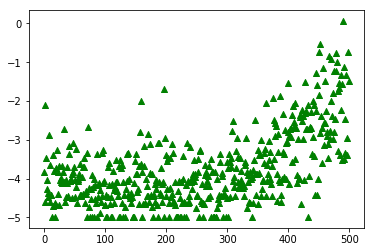

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
# ax.set_xlim(0.5, 4.5)
plt.show()